In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
#load images
car_images = glob.glob('training_data/vehicles/**/*.png')
noncar_images = glob.glob('training_data/non-vehicles/**/*.png')
print(len(car_images),'+', len(noncar_images),'=', len(car_images)+len(noncar_images))

8792 + 8968 = 17760


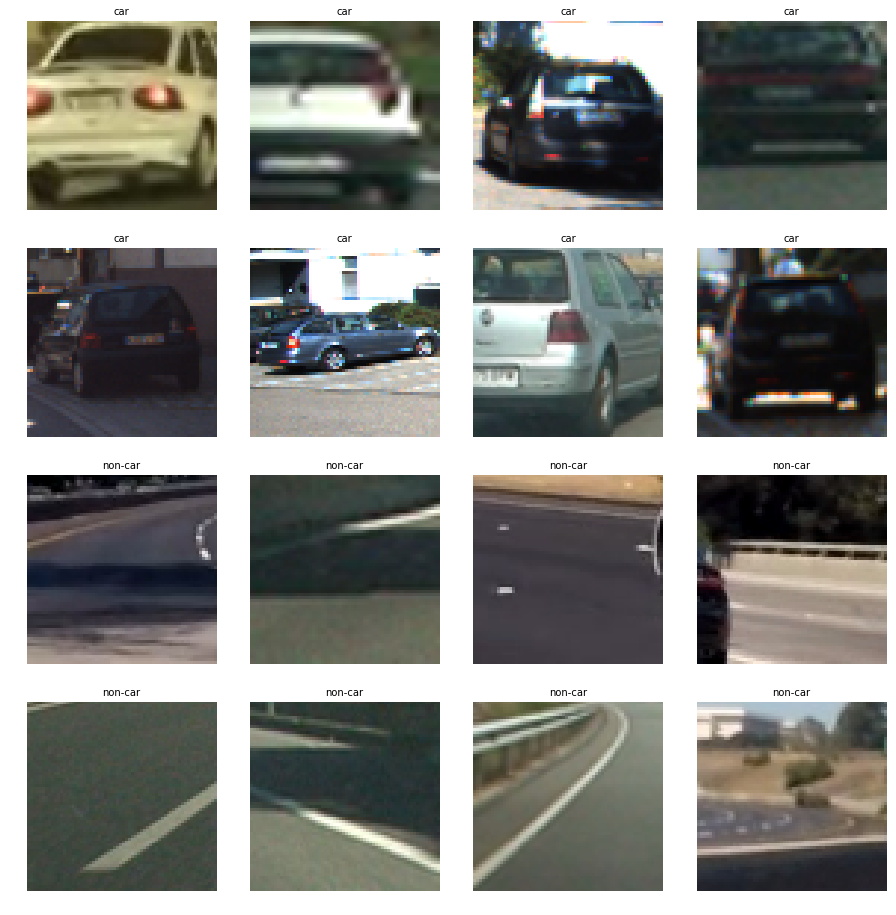

In [3]:
#Show cars and non-car examples
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

## Histogram of Oriented Gradients (HOG)

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

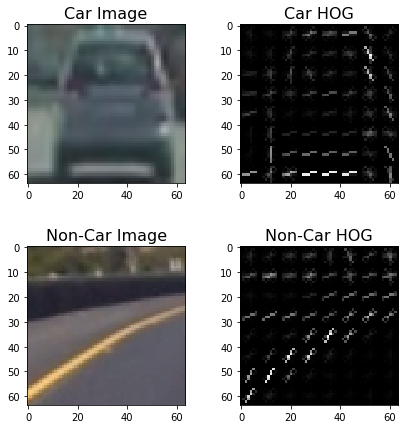

In [5]:
#Show car and non-car examples of HOG features 
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

In [6]:
# Define a function to extract features from a list of image locations

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
# X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

50.22 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.65 Seconds to train SVC...
Test Accuracy of SVC =  0.982
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.02307 Seconds to predict 10 labels with SVC


In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
             
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [10]:
#test on test images
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


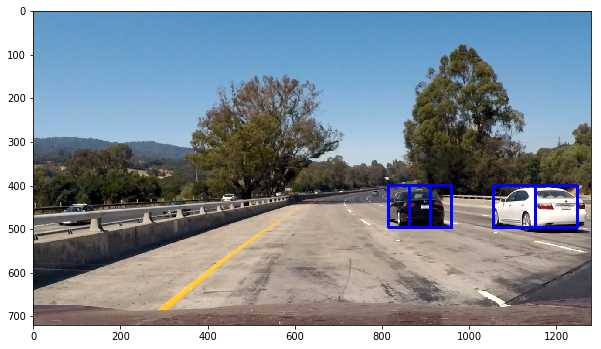

In [11]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## Sliding Window Search

In [38]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
#plt.figure(figsize=(10,10))
#plt.imshow(test_img_rects)

In [52]:
#Heatmap functions
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

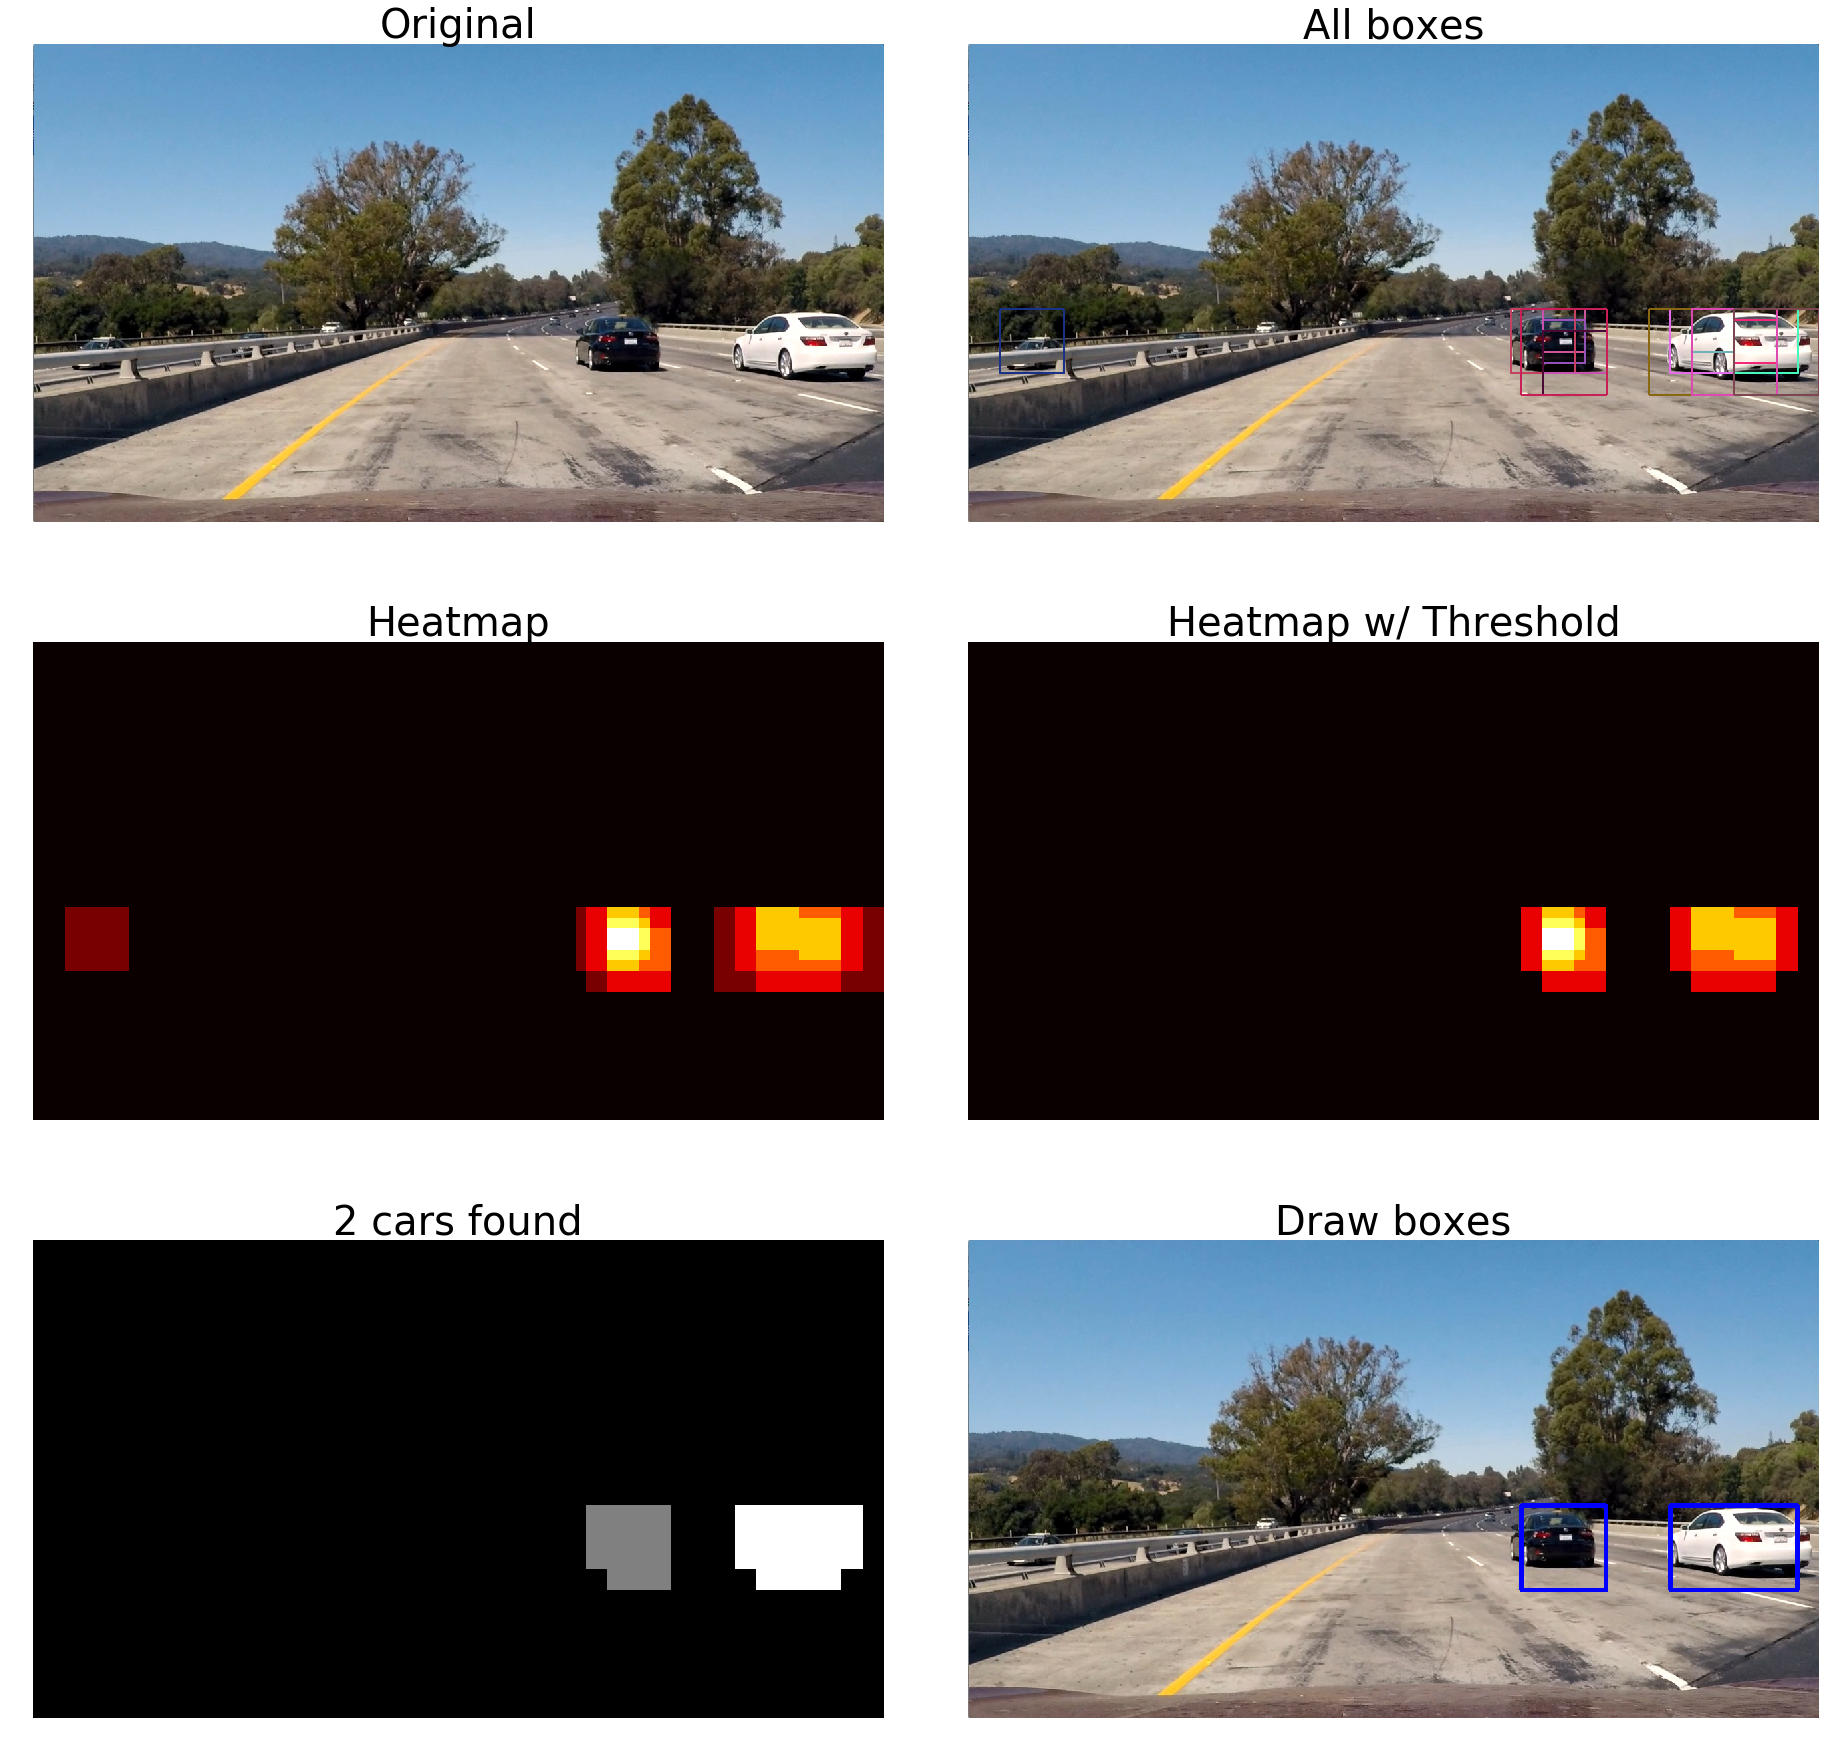

In [57]:
#Show how to get from many boxis to the required distinct number of cars identified (2 in this example)
fig, axs = plt.subplots(3,2, figsize=(32, 32))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('Original', fontsize=40)
axs[0].imshow(test_img)
axs[1].axis('off')
axs[1].set_title('All boxes', fontsize=40)
axs[1].imshow(test_img_rects)
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
axs[2].axis('off')
axs[2].set_title('Heatmap', fontsize=40)
axs[2].imshow(heatmap_img,cmap='hot')
heatmap_img = apply_threshold(heatmap_img, 1)
axs[3].axis('off')
axs[3].set_title('Heatmap w/ Threshold', fontsize=40)
axs[3].imshow(heatmap_img,cmap='hot')
labels = label(heatmap_img)
axs[4].axis('off')
axs[4].set_title('2 cars found', fontsize=40)
axs[4].imshow(labels[0], cmap='gray')
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
axs[5].axis('off')
axs[5].set_title('Draw boxes', fontsize=40)
axs[5].imshow(draw_img)

## Video Implementation

In [20]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

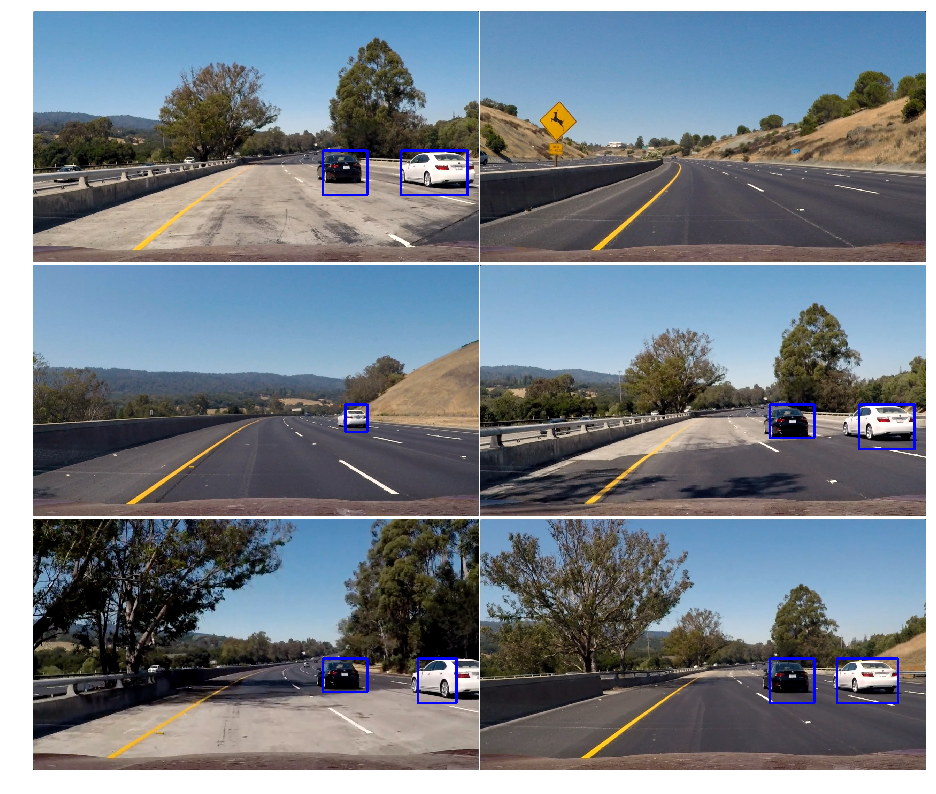

In [21]:
#test on the test images
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [22]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:12<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 13.6 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [24]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [25]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [26]:
det = Vehicle_Detect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:14<00:00,  3.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

Wall time: 15.2 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

In [28]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:05<00:00,  3.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 7min 6s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))